In [1]:
import numpy as np
import matplotlib.pyplot as plt
import itertools

from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline

from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier

from sklearn.inspection import permutation_importance
from sklearn.metrics import accuracy_score


In [2]:
data = np.load("data/dataset_rf.npz")
X = data["X"]
y = data["y"]

print("X shape:", X.shape)
print("y shape:", y.shape)

X shape: (4000, 10)
y shape: (4000,)


In [3]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=42, stratify=y
)
print("X_train shape:", X_train.shape)
print("X_test shape:", X_test.shape) 

X_train shape: (2800, 10)
X_test shape: (1200, 10)


In [4]:
models = {
    "Naive Bayes": GaussianNB(),
    "Logistic Regression": Pipeline([
        ("scaler", StandardScaler()),
        ("clf", LogisticRegression(max_iter=1000))
    ]),
    "kNN": Pipeline([
        ("scaler", StandardScaler()),
        ("clf", KNeighborsClassifier(n_neighbors=3))
    ]),
    "Random Forest": RandomForestClassifier(
        n_estimators=100,
        random_state=42
    )
}


In [5]:
results = {}

for name, model in models.items():
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    acc = accuracy_score(y_test, y_pred)
    results[name] = acc
    print(f"{name}: Accuracy = {acc:.3f}")


Naive Bayes: Accuracy = 0.901
Logistic Regression: Accuracy = 0.511
kNN: Accuracy = 0.828
Random Forest: Accuracy = 0.920


In [6]:
num_features = X.shape[1]

for i, j in itertools.combinations(range(num_features), 2):
    plt.figure()
    plt.scatter(X[:, i], X[:, j], c=y, cmap="viridis", s=10)
    plt.xlabel(f"Feature {i}")
    plt.ylabel(f"Feature {j}")
    plt.colorbar(label="Class")
    plt.title(f"Feature {i} vs Feature {j}")
    plt.tight_layout()
    plt.savefig(f"plots/task1/feature_{i}_{j}.png")
    plt.savefig(f"plots/task1/feature_{i}_{j}.eps", format="eps")
    plt.close()

In [7]:
rf = RandomForestClassifier(
    n_estimators=200,
    random_state=42
)
rf.fit(X_train, y_train)


,n_estimators,200
,criterion,'gini'
,max_depth,None
,min_samples_split,2
,min_samples_leaf,1
,min_weight_fraction_leaf,0.0
,max_features,'sqrt'
,max_leaf_nodes,None
,min_impurity_decrease,0.0
,bootstrap,True
,oob_score,False


In [8]:
importances = rf.feature_importances_

plt.figure()
plt.bar(range(len(importances)), importances)
plt.xlabel("Feature index")
plt.ylabel("Importance")
plt.title("Impurity-based Feature Importance")
plt.tight_layout()
plt.savefig("plots/task1/feature_importance_impurity.png")
plt.savefig("plots/task1/feature_importance_impurity.eps", format="eps")
plt.close()


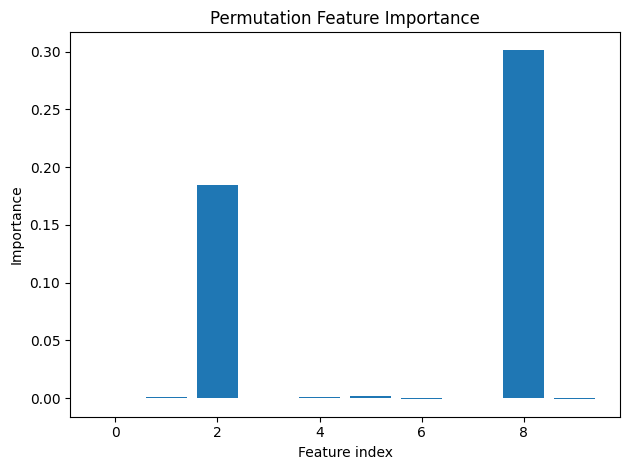

In [9]:
perm = permutation_importance(
    rf, X_test, y_test,
    n_repeats=20,
    random_state=42
)

plt.figure()
plt.bar(range(len(perm.importances_mean)), perm.importances_mean)
plt.xlabel("Feature index")
plt.ylabel("Importance")
plt.title("Permutation Feature Importance")
plt.tight_layout()
plt.savefig("plots/task1/feature_importance_permutation.png")
plt.savefig("plots/task1/feature_importance_permutation.eps", format="eps")


In [10]:
k = 3
top_features = np.argsort(importances)[-k:]
print("Top features:", top_features)


Top features: [5 2 8]


In [11]:
X_train_sel = X_train[:, top_features]
X_test_sel = X_test[:, top_features]

rf_sel = RandomForestClassifier(n_estimators=100, random_state=42)
rf_sel.fit(X_train_sel, y_train)

y_pred_sel = rf_sel.predict(X_test_sel)
acc_sel = accuracy_score(y_test, y_pred_sel)

print("RF accuracy with selected features:", acc_sel)


RF accuracy with selected features: 0.9216666666666666


In [12]:
trees = [5, 10, 25, 50, 100, 200]
oob_scores = []
cv_scores = []

for n in trees:
    rf = RandomForestClassifier(
        n_estimators=n,
        oob_score=True,
        bootstrap=True,
        random_state=42
    )
    rf.fit(X_train, y_train)
    oob_scores.append(rf.oob_score_)
    
    cv = cross_val_score(
        rf, X_train, y_train,
        cv=5
    ).mean()
    cv_scores.append(cv)


d:\ML\.myenv\Lib\site-packages\sklearn\ensemble\_forest.py:611: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(
d:\ML\.myenv\Lib\site-packages\sklearn\ensemble\_forest.py:611: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(
d:\ML\.myenv\Lib\site-packages\sklearn\ensemble\_forest.py:611: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(
d:\ML\.myenv\Lib\site-packages\sklearn\ensemble\_forest.py:611: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(
d:\ML\.myenv\Lib\site-packages\sklearn\ensemble\_forest.py:611: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB

In [13]:
plt.figure()
plt.plot(trees, oob_scores, label="OOB Score", marker="o")
plt.plot(trees, cv_scores, label="CV Score", marker="s")
plt.xlabel("Number of Trees")
plt.ylabel("Accuracy")
plt.legend()
plt.title("OOB vs Cross-Validation")
plt.tight_layout()
plt.savefig("plots/task1/oob_vs_cv.png")
plt.savefig("plots/task1/oob_vs_cv.eps", format="eps")
plt.close()


The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
